In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression



1. 데이터 로드

In [2]:
# 데이터 로드
data = pd.read_csv('machine_data.csv')
data

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,adviser,32/60,125,256,6000,256,16,128,198
1,amdahl,470v/7,29,8000,32000,32,8,32,269
2,amdahl,470v/7a,29,8000,32000,32,8,32,220
3,amdahl,470v/7b,29,8000,32000,32,8,32,172
4,amdahl,470v/7c,29,8000,16000,32,8,16,132
...,...,...,...,...,...,...,...,...,...
204,sperry,Aug-80,124,1000,8000,0,1,8,42
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46
206,sratus,32,125,2000,8000,0,2,14,52
207,wang,vs-100,480,512,8000,32,0,0,67


2.데이터 탐색

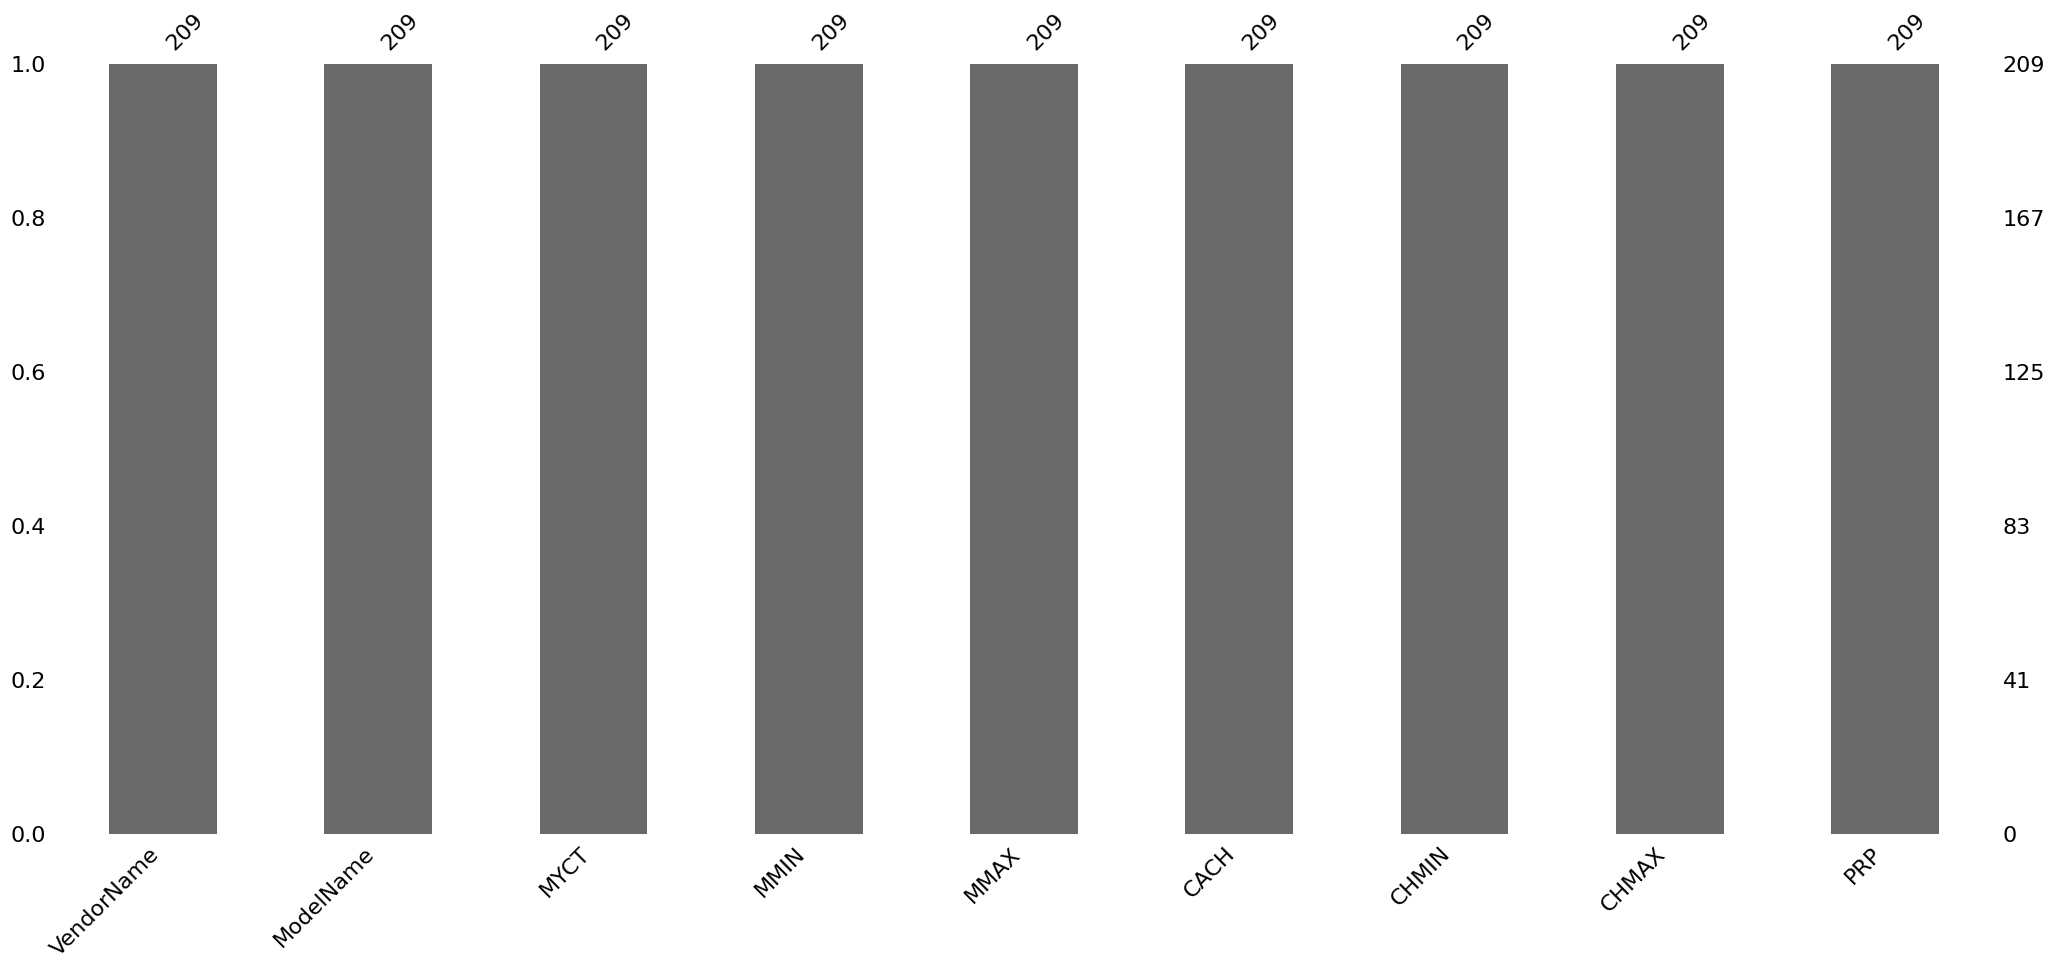

(209, 9)


In [3]:
# 결측치 시각화
msn.bar(data)
plt.show()

# 결측치 제거
data.dropna(inplace=True)
print(data.shape)

3. 중요 특징 추출

PRP      1.000000
MMAX     0.863004
MMIN     0.794931
CACH     0.662641
CHMIN    0.608903
CHMAX    0.605209
MYCT     0.307099
Name: PRP, dtype: float64
Top features: Index(['MMAX', 'MMIN', 'CACH', 'CHMIN'], dtype='object')


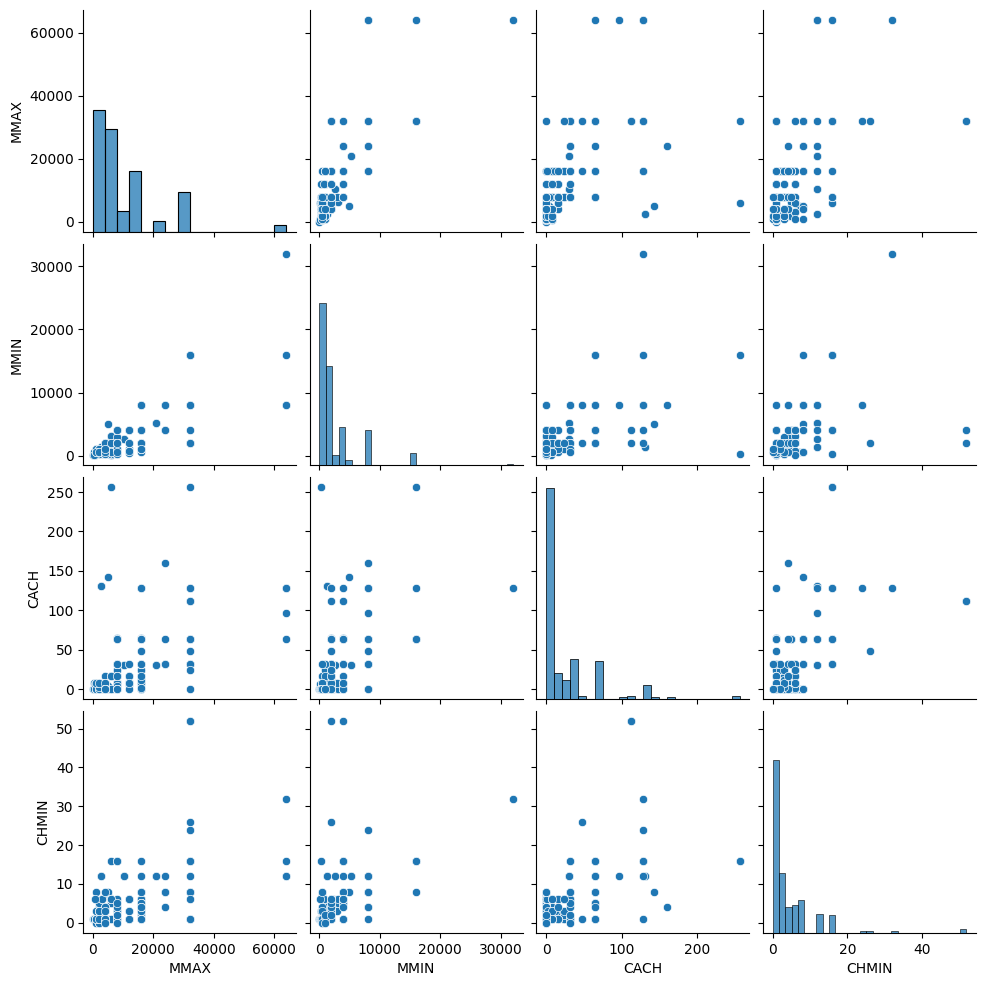

In [4]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
correlation_with_target = correlation_matrix['PRP'].abs().sort_values(ascending=False)
sorted_correlation = correlation_with_target.sort_values(ascending=False)
print(sorted_correlation)

top_features = sorted_correlation.index[1:5]
print(f'Top features: {top_features}')

sns.pairplot(data, vars=top_features)
plt.show()


4.X,y 설정

In [5]:
# X, y 선택
X = data[top_features]
y = data['PRP']

5. 학습데이터와 평가 데이터 분리

In [6]:
# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

6. 앙상블 기법 이용 모델 학습

In [7]:
# 파이프라인 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# 하이퍼파라미터 그리드 설정
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 설정 및 학습
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_mean_squared_error')

7.최적 파라미터 출력

In [8]:
# 최적 파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}


8. 최적 모델로 예측

In [9]:
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

9.예측 모델 성능 평가

In [10]:

# 학습 데이터 성능 평가
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
print(f"Train MSE: {train_mse}, Train MAE: {train_mae}, Train R^2: {train_r2}")

# 테스트 데이터 성능 평가
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f"Test MSE: {test_mse}, Test MAE: {test_mae}, Test R^2: {test_r2}")

Train MSE: 1662.913377435574, Train MAE: 16.733565376641828, Train R^2: 0.9088983458266581
Test MSE: 5364.709011140757, Test MAE: 36.23809501847107, Test R^2: 0.8975432612612477


10.  모델 결과 시각화

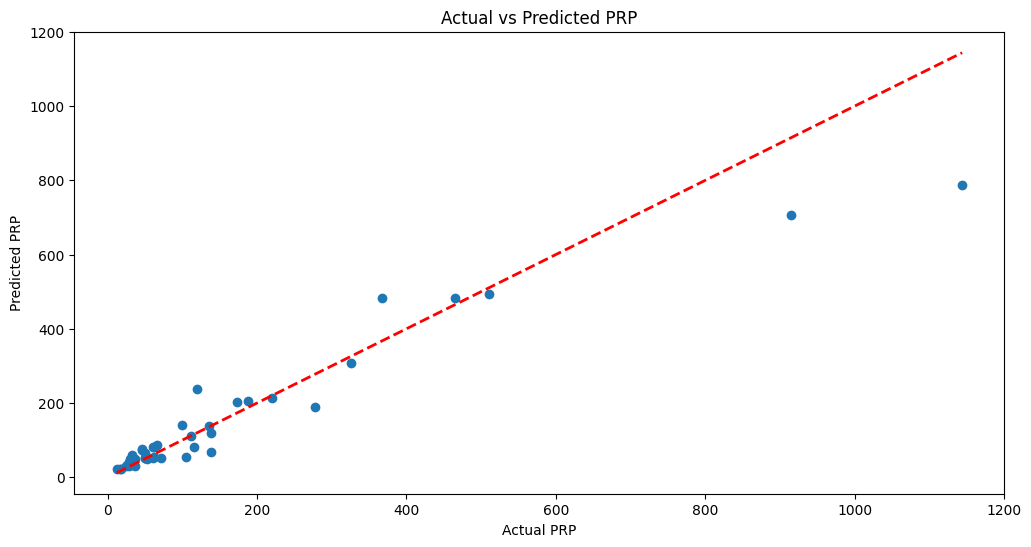

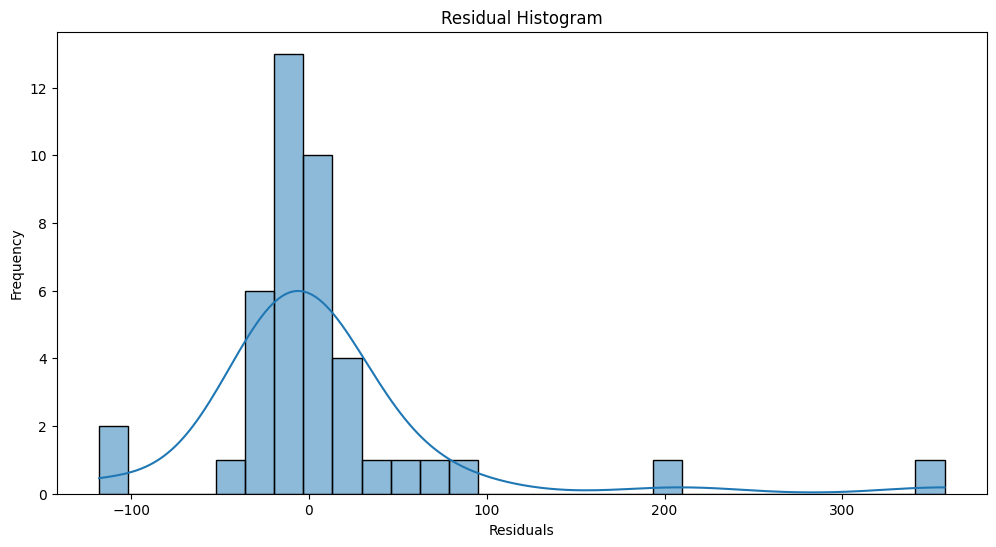

Final R^2 value: 0.8975432612612477


In [11]:
# 시각화: 실제 vs 예측
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual PRP")
plt.ylabel("Predicted PRP")
plt.title("Actual vs Predicted PRP")
plt.show()

# 시각화: 잔차 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(y_test - y_pred_test, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()

print(f"Final R^2 value: {test_r2}")

11. Pipeline 기반 모델 성능 평가

In [12]:
# 교차 검증
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f'Cross-validation R^2 scores: {cv_scores}')
print(f'Cross-validation R^2 mean: {np.mean(cv_scores)}')

Cross-validation R^2 scores: [0.52493169 0.81470611 0.80156121 0.82808175 0.86172018]
Cross-validation R^2 mean: 0.7662001872483318


12. 모델 개선 

In [13]:
# 파이프라인 설정 (다항 특징 추가)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', RandomForestRegressor())
])

# 하이퍼파라미터 그리드 설정
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# GridSearchCV 설정 및 학습
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# 최적 파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 학습 데이터 성능 평가
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
print(f"Train MSE: {train_mse}, Train MAE: {train_mae}, Train R^2: {train_r2}")

# 테스트 데이터 성능 평가
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print(f"Test MSE: {test_mse}, Test MAE: {test_mae}, Test R^2: {test_r2}")

# 교차 검증
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f'Cross-validation R^2 scores: {cv_scores}')
print(f'Cross-validation R^2 mean: {np.mean(cv_scores)}')

Best parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Train MSE: 1792.6091172845995, Train MAE: 16.38541613476344, Train R^2: 0.9017930470180678
Test MSE: 7385.082291965886, Test MAE: 43.20660257137042, Test R^2: 0.858957597629095
Cross-validation R^2 scores: [0.58909382 0.80865724 0.75019049 0.94891547 0.7112994 ]
Cross-validation R^2 mean: 0.7616312839632166


4. 성능 비교 시각화

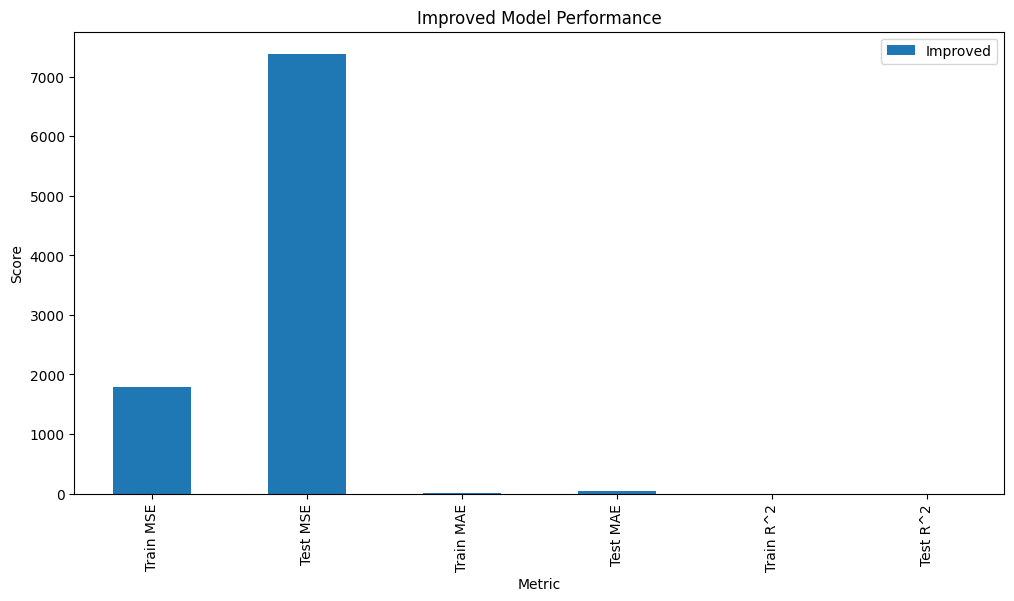

Final R^2 value: 0.858957597629095


In [14]:
# 성능 결과 데이터프레임 생성
results = {
    'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R^2', 'Test R^2'],
    'Improved': [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2]
}

results_df = pd.DataFrame(results)

# 성능 비교 시각화
results_df.set_index('Metric').plot(kind='bar', figsize=(12, 6))
plt.title('Improved Model Performance')
plt.ylabel('Score')
plt.show()

print(f"Final R^2 value: {test_r2}")